In [2]:
#Libraries
import matplotlib.pyplot as plt
import numpy as np

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-life $\tau$ of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

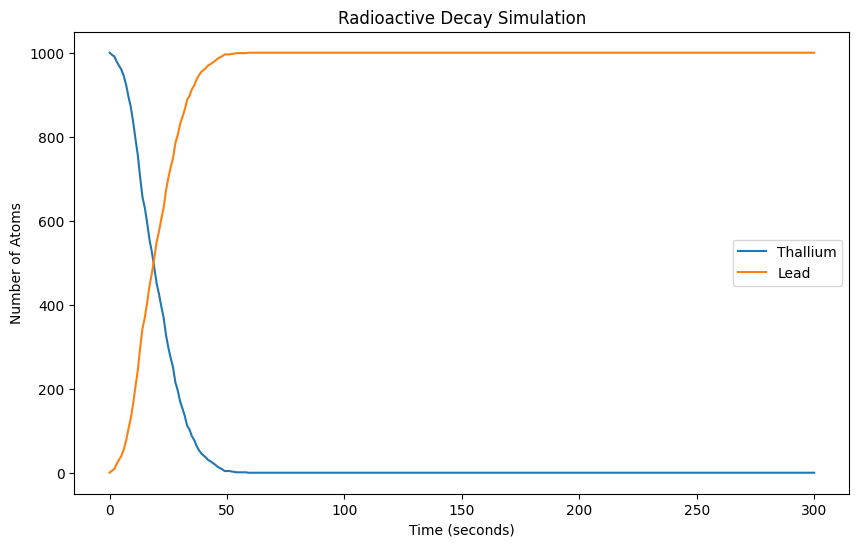

In [3]:
# Constants
tau = 3.052 * 60  # half-life in seconds
total_time = 300  # total simulation time in seconds
time_steps = np.arange(0, total_time + 1, 1)  # time steps

# Initial conditions
num_tl_atoms = 1000
num_pb_atoms = 0

# Simulation
tl_evolution = []
pb_evolution = []

for t in time_steps:
    decay_prob = 1 - 2 ** (-t / tau)
    decayed_tl = np.random.binomial(num_tl_atoms, decay_prob)
    
    num_tl_atoms -= decayed_tl
    num_pb_atoms += decayed_tl
    
    tl_evolution.append(num_tl_atoms)
    pb_evolution.append(num_pb_atoms)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_steps, tl_evolution, label='Thallium')
plt.plot(time_steps, pb_evolution, label='Lead')
plt.title('Radioactive Decay Simulation')
plt.xlabel('Time (seconds)')
plt.ylabel('Number of Atoms')
plt.legend()
plt.show()

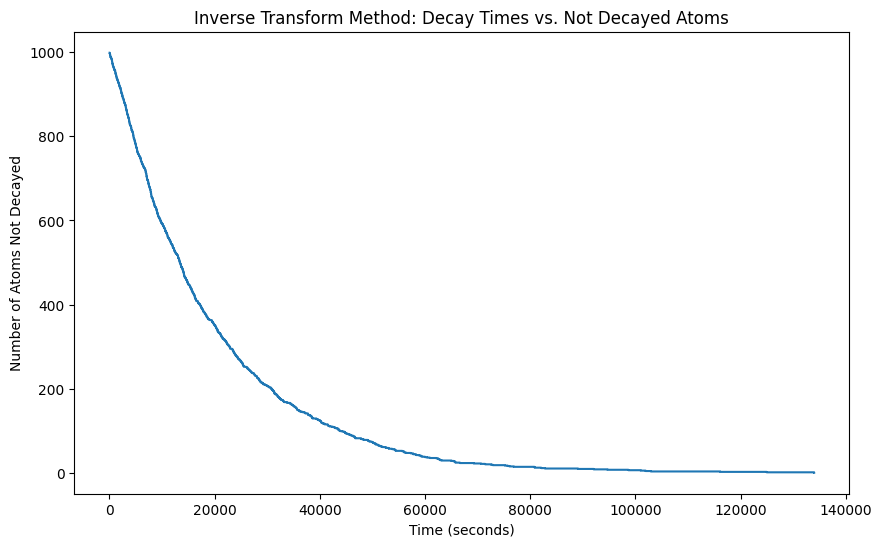

In [10]:
import matplotlib.pyplot as plt
import numpy as np

num_atoms = 1000  # number of Thallium atoms

# Generate random numbers from the non-uniform probability distribution
random_numbers = -tau * np.log(1 - np.random.rand(num_atoms))

# Sort the random numbers to get the decay times
decay_times = np.sort(random_numbers)

# Calculate the number of atoms that have not decayed at each time step
not_decayed_atoms = num_atoms - np.arange(1, num_atoms + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.step(decay_times, not_decayed_atoms, where='post')
plt.title('Inverse Transform Method: Decay Times vs. Not Decayed Atoms')
plt.xlabel('Time (seconds)')
plt.ylabel('Number of Atoms Not Decayed')
plt.show()

2\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function: 

$$f(x) =\sin^2{\left( \frac{1}{1-x} \right)}$$

* Plot the function and compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate (hint: repeat the integral $N$ times, and from the distribution of the integrals take the mean value and the standard deviation, the latter rescaled by the appropriate factor)
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one.

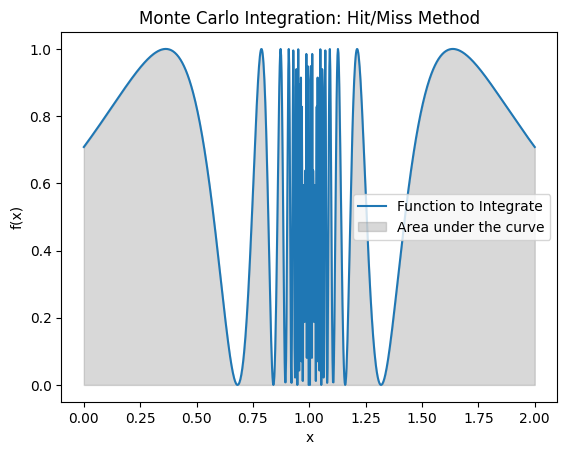

Integral estimate (Hit/Miss method): 1.3366
Mean error: 1.34458952
Standard deviation of error (rescaled): 8.442988225125036e-05


In [11]:
# Function to integrate
def f(x):
    return np.sin(1 / (1 - x))**2

# Integration limits
a, b = 0, 2

# Number of Monte Carlo samples
N = 10000

# Generate random points in the integration range
random_x = np.random.uniform(a, b, N)
random_y = np.random.uniform(0, 1, N)

# Evaluate the function at the random points
fx = f(random_x)

# Count the number of points below the curve
below_curve = random_y < fx

# Estimate the integral using the hit/miss method
integral_estimate = (below_curve.sum() / N) * (b - a)

# Estimate the error
integral_values = np.zeros(N)
for i in range(N):
    random_x = np.random.uniform(a, b, N)
    fx = f(random_x)
    below_curve = random_y < fx
    integral_values[i] = below_curve.sum() / N * (b - a)

error_mean = np.mean(integral_values)
error_std = np.std(integral_values) / np.sqrt(N)

# Plotting the function
x_values = np.linspace(a, b, 1000)
plt.plot(x_values, f(x_values), label='Function to Integrate')
plt.fill_between(x_values, 0, f(x_values), color='gray', alpha=0.3, label='Area under the curve')

plt.title('Monte Carlo Integration: Hit/Miss Method')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

# Output the results
print(f"Integral estimate (Hit/Miss method): {integral_estimate}")
print(f"Mean error: {error_mean}")
print(f"Standard deviation of error (rescaled): {error_std}")


In [12]:
# Repeat the integration using the mean value method
mean_value_estimate = np.mean(fx) * (b - a)

# Estimate the error for mean value method
error_mean_value = np.abs(mean_value_estimate - integral_estimate)

# Output the results for mean value method
print("\nMean Value Method:")
print(f"Integral estimate (Mean Value method): {mean_value_estimate}")
print(f"Error compared to Hit/Miss method: {error_mean_value}")


Mean Value Method:
Integral estimate (Mean Value method): 1.3544136308274601
Error compared to Hit/Miss method: 0.017813630827460125


3\. **Monte Carlo integration in high dimension**

* Compute the area of a circle of unit radius, by integrating the function:

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere.

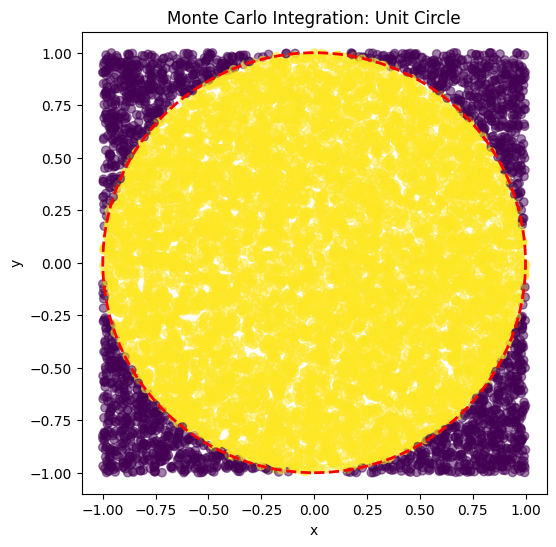

Area estimate of the unit circle: 3.1464


In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Function to integrate for the unit circle
def f_circle(x, y):
    return (x**2 + y**2) <= 1

# Number of Monte Carlo samples
N = 10000

# Generate random points in the square [-1, 1] x [-1, 1]
random_x = np.random.uniform(-1, 1, N)
random_y = np.random.uniform(-1, 1, N)

# Evaluate the function at the random points
inside_circle = f_circle(random_x, random_y)

# Estimate the area of the unit circle
area_estimate = (inside_circle.sum() / N) * 4  # Multiplying by 4 to account for the whole square

# Plotting the unit circle and sampled points
plt.figure(figsize=(6, 6))
plt.scatter(random_x, random_y, c=inside_circle, cmap='viridis', alpha=0.5)
circle = plt.Circle((0, 0), 1, color='r', fill=False, linestyle='dashed', linewidth=2)
plt.gca().add_patch(circle)
plt.title('Monte Carlo Integration: Unit Circle')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Output the results
print(f"Area estimate of the unit circle: {area_estimate}")

In [16]:
# Function to integrate for the 10D sphere
def f_10D_sphere(coordinates):
    return np.sum(coordinates**2, axis=1) <= 1

# Number of Monte Carlo samples for the 10D sphere
N_10D = 10000

# Generate random points in the 10D hypercube [-1, 1]^10
random_coordinates = np.random.uniform(-1, 1, (N_10D, 10))

# Evaluate the function at the random points for the 10D sphere
inside_10D_sphere = f_10D_sphere(random_coordinates)

# Estimate the volume of the 10D sphere
volume_estimate_10D = (inside_10D_sphere.sum() / N_10D) * (2**10)  # Multiplying by (2^10) for the whole hypercube

# Output the results for the 10D sphere
print(f"\nVolume estimate of the 10D sphere: {volume_estimate_10D}")


Volume estimate of the 10D sphere: 2.3552


4\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should expect a result around 0.84.

In [18]:
# Function to integrate
def f(x):
    return 1 / (x**0.5 * (np.exp(x) + 1))

# Weight function
def w(x):
    return 1 / np.sqrt(x)

# Number of Monte Carlo samples
N = 100000

# Generate random points according to the weight function
random_points = np.random.uniform(0, 1, N)**2

# Evaluate the function at the random points
integral_estimate = np.mean(f(random_points) / w(random_points))

# Output the result
print(f"Integral estimate using importance sampling: {integral_estimate}")


Integral estimate using importance sampling: 0.4197470027230867
